# A viscoplastic shallow ice shelf model

## Problem description

Consider a 1D floating ice shelf, flowing viscously in accordance with the SSA, with depth-averaged velocity $u$ and net depth-integrated stress of $H\overline{\sigma}$, but with a viscoplastic deflection $\eta$ and bending moment $M$ resulting in a nonzero height above buoyancy, $h_{ab}$. The shelf will melt backward from the front at exactly the flow rate, which will save us having to track the ice front progression. The shelf obeys the four equations below, which slightly modify [Macayeal et al. (2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3):

$$M'' - \rho_wgh_{ab} + H\overline{\sigma}\eta'' = 0$$
$$\eta'' = \Phi_\nu + \Phi_p$$
$$\dot{\Phi}_\nu + u\Phi_\nu'= -\frac{1}{C}M$$
$$\dot{\Phi}_p + u\Phi_p' = \frac{1}{C}(M - M^*)$$

where $\Phi_\nu$ is the viscous curvature, $\Phi_p$ is the plastic curvature, $C := \frac{\nu H^3}{3}$ is the flexural viscosity, and $M^*$ given as some function of the bending moment, which we elaborate on below. The first equation is the balance of forces in a flowing, flexing medium, the final three together incorporate the viscoelastic-plastic constitutive relation. If we further define the viscoplastic curvature to be $\Phi := \Phi_\nu + \Phi_p$, then we obtain the reduced form below. 

$$M'' - \rho_wgh_{ab} + H\overline{\sigma}\eta'' = 0$$
$$\eta'' = \Phi$$
$$\dot{\Phi} + u\Phi' = -\frac{1}{C}M^*$$

We can continue to simplify by taking the total time derivative of the second equation and substituting into the third, providing the final form:

$$M'' - \rho_wgh_{ab} + H\overline{\sigma}\eta'' = 0$$
$$\dot{\eta}'' = -\frac{1}{C}M^*$$

## Defining the adjusted bending moment $M^*$

We'll define $M^*$ to differ from $M$ only where the magnitude of $M$ exceeds a critical value, $M_c$. We'll do this by choosing an appropriate piecewise-defined scalar $k$ with $M^* := kM$. The multiplier $k$ is defined as below:

$$k = \begin{cases}
1 & |M| \leq M_c \\
\frac{M_c + \alpha(|M| - M_c)}{|M|} & |M| > M_c
\end{cases}$$

Here $0 \leq \alpha \leq 1$ is a tunable parameter that allows us to control how "sharply" the bending moment upper bound is imposed. For example, if $\alpha = 0$, then whenever $|M| > M_c$, there is a sharp cap imposed on $M^*$, with $|M^*| = |kM| = k|M| = \frac{M_c}{|M|}|M| = M_c$. At the other extreme, if $\alpha = 1$, then $|M^*| = |M|$ everywhere. For values in between, $|M^*|$ is scaled linearly whenever $M_c$ is exceeded, so that any growth beyond $M_c$ is somewhat dampened. The motivation for this scaling parameter is that the solver often fails when sharp kinks appear in $M^*$, but converges with more moderate values of $\alpha$. 

## Solution strategy

We will first model the system toward steady state geometry and velocity using functionality from icepack, and then solve the above equations iteratively from that steady-state starting point. With superscripts denoting the solution at a given timestep, the $t$th solution will be approximated first by solving the system 

$$\left(M^{(t)}\right)'' - \rho_wg\left(h_{ab}^{(t - 1)} + \dot{\eta}^{(t)}\Delta t\right) + H\overline{\sigma}\left(\eta^{(t - 1)} + \dot{\eta}^{(t)}\Delta t\right)'' = 0$$
$$\left(\dot{\eta}^{(t)}\right)'' + \frac{1}{C}M^{*(t)} = 0$$

where we express $M^*$ in terms of $M$, so that we have a system of only two unknows.

## Variational form

Let $n$ and $m$ be arbitrary functions in $x$. We must have  

$$\int_xn\left(M^{(t)}\right)'' - \int_xn\rho_wg\dot{\eta}^{(t)}\Delta t + \int_xnH\overline{\sigma} \left(\dot{\eta}^{(t)}\right)''\Delta t = \int_xn\rho_wgh_{ab}^{(t - 1)} - \int_xnH\overline{\sigma}\left(\eta^{(t - 1)}\right)''$$
$$\int_xm\left(\dot{\eta}^{(t)}\right)'' + \int_xm\frac{1}{C}M^{*(t)} = 0$$

and so, integrating all second derivatives by parts and omitting boundary terms, it follows that 

$$-\int_xn'\left(M^{(t)}\right)' - \int_xn\rho_wg\dot{\eta}^{(t)}\Delta t - \int_x\left(nH\overline{\sigma}\right)'\left(\dot{\eta}^{(t)}\right)'\Delta t = \int_xn\rho_wgh_{ab}^{(t - 1)} + \int_x\left(nH\overline{\sigma}\right)'\left(\eta^{(t - 1)}\right)'$$

$$-\int_xm'\left(\dot{\eta}^{(t)}\right)' + \int_xm\frac{1}{C}M^{*(t)} = 0$$

## Boundary conditions

At the terminula boundary, we use the flexure associated with the buoyancy moment of the terminal cliff, as explored by [Reeh (1968)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/on-the-calving-of-ice-from-floating-glaciers-and-ice-shelves/0E16F201FB4FF676826078C7C5F487DE). The boundary conditions for this problem are below:

- At the upstream boundary to the left, denoted $\Gamma(1)$, assume that grounding line acts as a hinge, permitting neither deflection nor bending. Then $\eta^{(t)} = M^{(t)} = 0$ on $\Gamma(1)$ at every timestep. We enforce these using ```DirichletBC```.
- At the cliff boundary to the right, denoted $\Gamma(2)$, we can impose a no-shear condition, so that $\left(M^{(t)}\right)' = 0$ on $\Gamma(2)$ at every timestep. This is enforced using the penalty method.
- Also at the cliff, $M^{(t)} = -\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)$, where $\varrho$ is the proportion of ice thickness below the waterline [(Lipovsky, 2020)](https://tc.copernicus.org/articles/14/1673/2020/). Note that this proportion is generally not equal to $\frac{\rho_i}{\rho_w}$, but instead will vary with time, as the terminus of the shelf will deflect downward from its equilibrium position. This final boundary condition is enforced by adding the boundary term

$$
\int_{\Gamma(2)} m M^{(t)} = -\int_{\Gamma(2)}m\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)
$$

## Solution options

We can solve either a flow-flexure problem or simply a flexure problem by setting ```flow = True``` or ```False``` (in either case, we first spin up to stead-state geometry via flow modeling). Furthermore, we can select which types of flexure to consider. Any combination of viscous, elastic, and plastic is possible. 

In [1]:
flow = True #set to true if solving a coupled flow-flexure problem, false if solving only flexure
M_c = 1e8 #critical bending moment for plasticity

gif = False #save multiple images to create a gif (more interesting), or output a single image (faster)

path = '/home/firedrake/H3F/figures/AGU_2024_figures' #path of preferred destination for saving figures

## Imports

In [2]:
%%capture

from firedrake import *
import icepack
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from operator import itemgetter
import os
import tqdm

!pip install import_ipynb #this block is to allow importing transport_solver, which is not yet a part of icepack
import import_ipynb
os.chdir('/home/firedrake/H3F/notebooks/flow/') #location of the transport solver notebook
from transport_solver_1D import TransportEquation, TransportSolver
os.chdir(path)

## Material parameters

In [3]:
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravitational constant (N/kg)
H_gl = 500 #grounding line thickness in meters
year = icepack.constants.year #number of seconds in a year
ν = 1e14/year #baseline flexural viscosity in (Pa yr)
T = Constant(273.15) #temperature in K
A = icepack.rate_factor(T) 
u_gl = 200 #grounding line velocity boundary condition in meters per year

## Meshing 

In [4]:
nx = 100 #number of nodes
Lx = 5000 #length of domain
mesh = IntervalMesh(nx, Lx)

Δt = 1/20000 #timestep 
num_years = 1/10 #choose how many years to model
num_timesteps = int(num_years/Δt) + 1 #number of timesteps

Q = FunctionSpace(mesh, 'CG', 3)
QQ = Q*Q #mixed function space for (η, M)

q = Function(QQ) #q = (η solution, M solution, M* solution)
n, m = TestFunctions(QQ) #test functions
η, M = split(q) #Trial functions

η_prev = Function(Q).project(Constant(0))
M_prev = Function(Q).project(Constant(0))

u_trial = TrialFunction(Q) #trial function for the velocity
v = TestFunction(Q) #test function for velocity
u = Function(Q) #this variable will store the actual velocity solution

x, = SpatialCoordinate(mesh)
X = np.arange(0, Lx, 1) #for plotting longitudinal profiles

## Spin up geometry to steady state

Obtain initial (pre-flexure) steady state by iteratively solving for velocity $u$ and thickness $H$. We can do this using the observation that, in the case of 1D shallow-shelf flow, the general solution for $\overline{\tau}$ is 

$$\overline{\tau} = \frac{1}{4}\rho_igH - \frac{1}{4H}\rho_wg(s - H)^2,$$

and so the velocity field must satisfy 

$$ u' = A\left(\frac{1}{4}\rho_igH - \frac{1}{4H}\rho_wg(s - H)^2\right)^n.$$

We can easily put this into the appropriate variational form for solving with Firedrake, given arbitrary function $v = v(x)$:

$$\int_xvu' = \int_xvA\tau^n.$$


Meanwhile, we will updated the surface and basal elevations each step via icepack's advection solver. Note also that the depth-averaged net stress associated with this solution is 

$$\overline{σ} = -\rho_w g\frac{(s - H)^2}{2H},$$

which will be used in the flexure solver later. 

In [5]:
######################################
######################################
### initialize values to be solved ###
######################################
######################################

H = Function(Q).project(Constant(H_gl)) #initial thickness
s = Function(Q).project((1 - ϱ)*H) #initial surface elevation
b = Function(Q).project(-ϱ*H) #initial basal elevation


##############################
##############################
### initialize the solvers ###
##############################
##############################

conservative_transport_model = TransportEquation(field_name = 'field', conservative = True) #for conservative advection problems
conservative_transport_solver = TransportSolver(conservative_transport_model) #e.g., mass transport

BC_u = DirichletBC(Q, u_gl, 1) #constrain velocity at the grounding line to be u_gl

###########################
###########################
### attain steady state ###
###########################
###########################

residence_time = int(Lx/u_gl) #estimated number of years for grounding line ice to reach the terminus
dt = 1 #set the timestep to one year

for step in tqdm.trange(residence_time):
    
    τ = Function(Q).project((1/4*ρ_i*g*H - 1/(4*H)*ρ_w*g*(s - H)**2)/1e6) #analytic, 1D expression for τ
    a = grad(u_trial)[0]*v*dx 
    L = v*A*τ**3*dx
    solve(a == L, u, bcs = [BC_u]) #obtain the velocity

    s = conservative_transport_solver.prognostic_solve(dt, field = s, velocity = u, #update the surface
                                            field_accumulation = Constant(0), field_inflow = s)
    
    b = conservative_transport_solver.prognostic_solve(dt, field = b, velocity = u, #update the base
                                            field_accumulation = Constant(0), field_inflow = b)
    H = Function(Q).project(s - b)

##########################################################
##########################################################
### define some geometry- and flow-depedent parameters ###
##########################################################
##########################################################

ν = Function(Q).project(1/2*1e6/(A*τ**(3 - 1))) #flexural viscosity
σ = -b**2/(2*H)*ρ_w*g if flow else Constant(0) #net stress
σ = Function(Q).project(σ)
ϱ = Function(Q).project(1 - s/H)
C = 1/3*ν*H**3

100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  6.31it/s]


## Plot the initial steady-state configuration

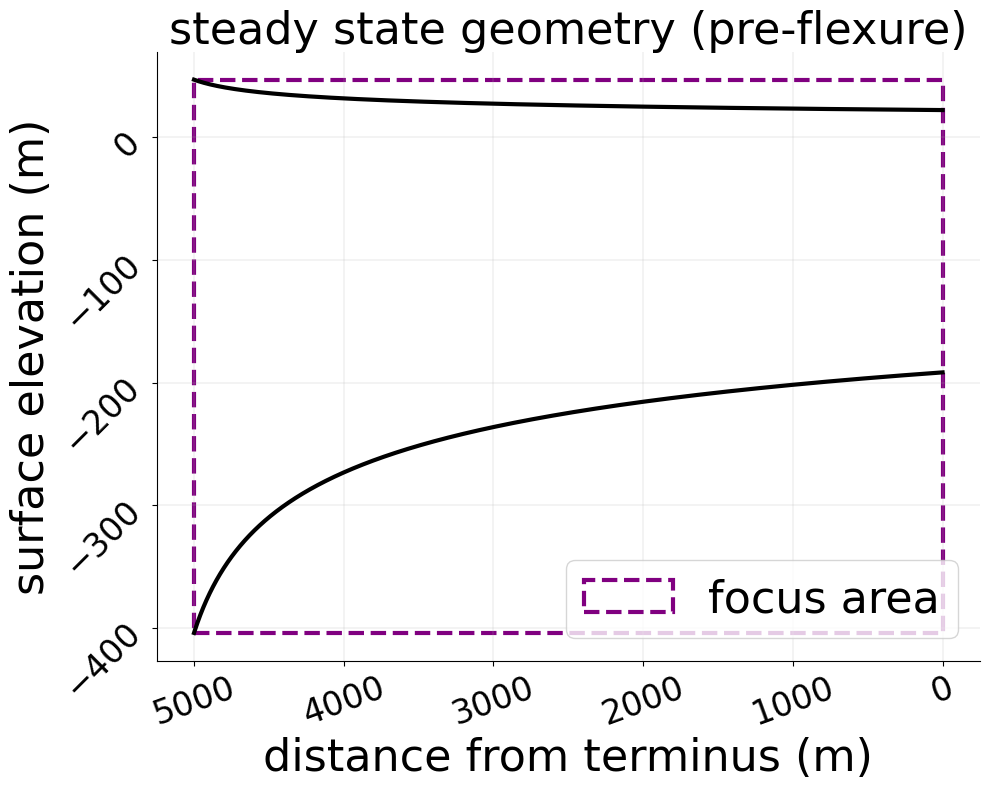

In [6]:
y_min, y_max = 7, 19 #for bounding the plots. if unsure which values are appropriate, comment this line out
title_size = 32
tick_size = 24
label_size = 32
start = -Lx #how close to the terminus should we view?

offset = int(H.at(Lx, tolerance = 1e-10)*0.99) - 2 #for shifting up the base to plot alongside surface elevation
point = Lx + start #we'll plot the progression of a point for sense of motion in the gifs
s1 = s.at(point, tolerance = 1e-10) #surface elevation at our chosen point

s_0_profile = s.at(X, tolerance = 1e-10) #the profiles to plot
b_0_profile = Function(Q).project(b + offset).at(X, tolerance = 1e-10)

if not flow: #find an appropriate title for the plot
    name = 'flexure'
else:
    name = 'flow + flexure'


fig, ax = plt.subplots(figsize = (10, 8))
plt.title('steady state geometry (pre-flexure)', fontsize = title_size)
plt.plot(s_0_profile[::-1], color = 'k', linewidth = 3)
plt.plot(b.at(X, tolerance = 1e-10)[::-1], color = 'k', linewidth = 3)
plt.xlabel('distance from terminus (m)', fontsize = label_size)
plt.ylabel('surface elevation (m)', fontsize = label_size)
plt.xticks(fontsize = tick_size, rotation = 20)
plt.yticks(fontsize = tick_size, rotation = 45)
plt.gca().invert_xaxis()
plt.grid(linewidth=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

try:
    corner_x = -start
    corner_y = float(b.at(Lx + start, tolerance = 1e-10) - s.at(0, tolerance = 1e-10) + s.at(Lx + start, tolerance = 1e-10))
    box_length = start
    box_height = s.at(0, tolerance = 1e-10) - corner_y
    box = patches.Rectangle((corner_x, corner_y), box_length, box_height, linewidth = 3, 
                            edgecolor = 'purple', facecolor = 'none', linestyle = 'dashed', label = 'focus area')
    ax.add_patch(box)
except:
    pass
plt.legend(loc = 'lower right', fontsize = label_size)
plt.tight_layout()
plt.savefig('initial_configuration')

## Choose an appropriate expression for $M^*$

As discussed in a previous notebook, we define $M^*$ via 

$$M^* = f(M) = \begin{cases}
M & -M_c \leq M \leq M_c \\
-M_c & M < -M_c \\
M_c & M > M_c 
\end{cases}$$

In [7]:
M_c = 1e8 #critical moment in Newtons

## Solve with firedrake

From the variational form derived above, define 

$$ a := -\int_xn'\left(M^{(t)}\right)' - \int_xn\rho_wg\dot{\eta}^{(t)}\Delta t - \int_x\left(nH\overline{\sigma}\right)'\left(\dot{\eta}^{(t)}\right)'\Delta t - \int_xm'\left(\dot{\eta}^{(t)}\right)' + \int_xm\frac{1}{C}M^{*(t)} + \int_{\Gamma(2)} \vartheta M^{(t)}$$

$$L := \int_xn\rho_wgh_{ab}^{(t - 1)} + \int_x\left(nH\overline{\sigma}\right)'\left(\eta^{(t - 1)}\right)' - \int_{\Gamma(2)}\vartheta\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)$$

We will solve the problem $a - L = 0$ subject to the additional boundary conditions discussed earlier.

100%|███████████████████████████████████████████████████████████████████████████████| 2001/2001 [03:21<00:00,  9.93it/s]


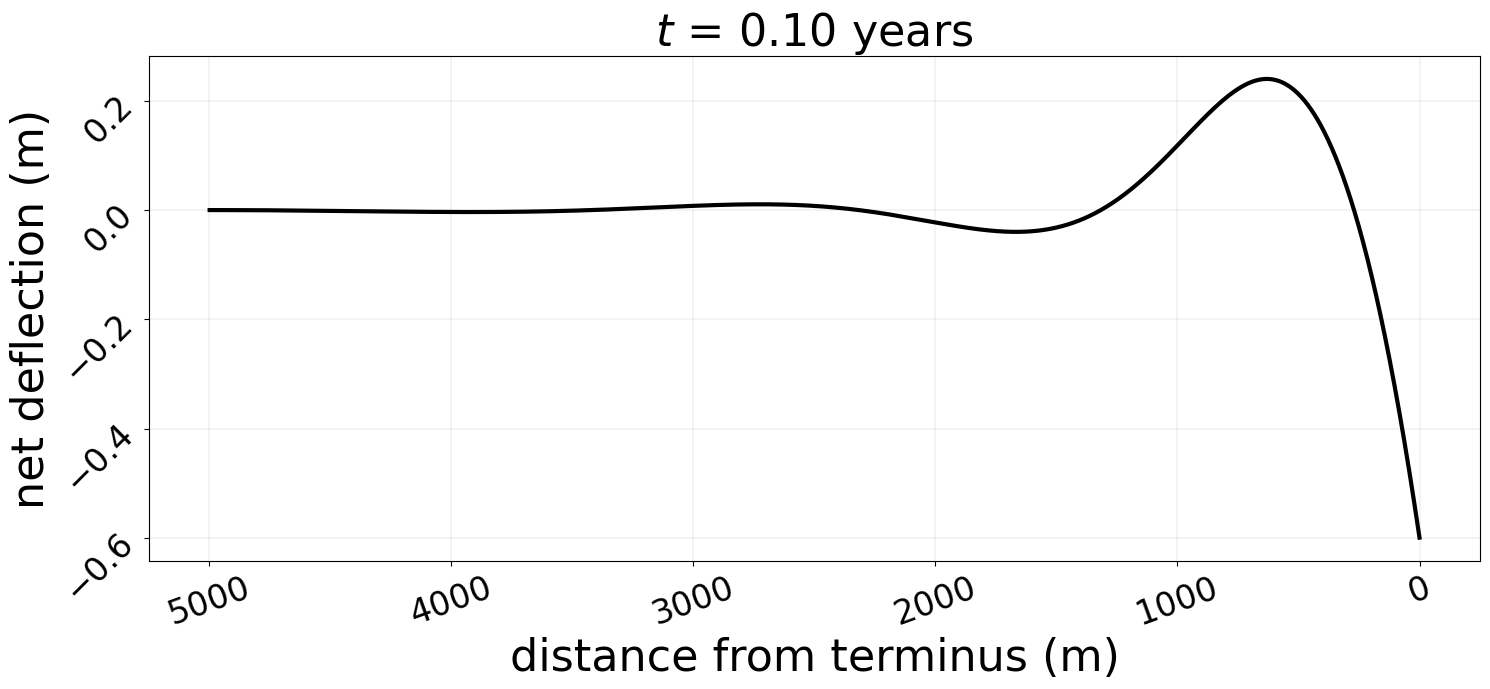

In [8]:
####################################
####################################
### initialize remaining solvers ###
####################################
####################################

nonconservative_transport_model = TransportEquation(field_name = 'field', conservative = False) #for nonconservative advection
nonconservative_transport_solver = TransportSolver(nonconservative_transport_model) #e.g., Φ, eventually damage

u = u if flow else Function(Q).project(Constant(0)) #set velocity to 0 if flow == False

BC_η = DirichletBC(QQ.sub(0), 0, 1) #η = 0 upstream
BC_M = DirichletBC(QQ.sub(1), 0, 1) #M = 0 upstream

#########################
#########################
### solve iteratively ###
#########################
#########################

for step in tqdm.trange(num_timesteps):

    #########################
    #########################
    ### obtain flow field ###
    #########################
    #########################
    
    if flow:
        
        τ = Function(Q).project((1/4*ρ_i*g*H - 1/(4*H)*ρ_w*g*(s - H)**2)/1e6) 
        a = grad(u_trial)[0]*v*dx 
        L = v*A*τ**3*dx
        solve(a == L, u, bcs = [BC_u]) #obtain the velocity

        s = conservative_transport_solver.prognostic_solve(Δt, field = s, velocity = u, #update the surface
                                                field_accumulation = Constant(0), field_inflow = s)
        
        b = conservative_transport_solver.prognostic_solve(Δt, field = b, velocity = u, #update the thickness
                                                field_accumulation = Constant(0), field_inflow = b)

        s = Function(Q).project(s)
        H = Function(Q).project(s - b) #thickness changes only if flow == True
        σ = Function(Q).project(-b**2/(2*H)*ρ_w*g) #update the flow stress
        ν = Function(Q).project(1/2*1e6/(A*τ**(3 - 1)))

        
    ######################################
    ######################################
    ### update any evolving parameters ###
    ######################################
    ######################################
    
    h_ab = Function(Q).project(s - (1 - ρ_i/ρ_w)*H)
    ϱ = Function(Q).project(1 - s/H)
    C = 1/3*ν*H**3

    q = Function(QQ)
    η, M = split(q)
    α = 1/10
    J_II = abs(M) #the magnitude of M is technically the second invariant of this 1D "tensor"
    k = conditional(J_II > M_c, (M_c + α*(J_II - M_c))/J_II, 1)
    M_star = k*M
        
    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################
    
    a = -grad(n)[0]*grad(M)[0]*dx - n*ρ_w*g*η*Δt*dx - grad(n*H*σ)[0]*grad(η)[0]*Δt*dx + n*M*ds(2)
    a += -grad(m)[0]*grad(η)[0]*dx + m*1/C*M_star*dx
    L = -n*1/12*ρ_i*g*H**3*(2*ϱ**2 - 3*ϱ + 1)*ds(2) + n*ρ_w*g*η_prev*dx + grad(n*H*σ)[0]*grad(η_prev)[0]*dx
        
    a += 1/2*(1e10)**2*m*grad(M)[0]*ds #M' = 0 at both boundaries via the penalty method
    a += 1/2*(1e10)**2*grad(n)[0]*grad(η)[0]*ds(1)
    
    solve(a - L == 0, q, bcs = [BC_η, BC_M])
    
    #######################################
    #######################################
    ### update and advect stored values ###
    #######################################
    #######################################

    Δη = η*Δt
    η_prev = Function(Q).project(η_prev + Δη) 
    s = Function(Q).project(s + Δη)
    b = Function(Q).project(b + Δη)

    η_prev = nonconservative_transport_solver.prognostic_solve(Δt, field = η_prev, velocity = u, field_inflow = η_prev,
                                                           field_accumulation = Constant(0))
    η_prev = Function(Q).project(η_prev)

    
    ####################################################
    ####################################################
    ### plot as multiple images for making a gif... ####
    ####################################################
    ####################################################
    
    if gif:
        if step % 5 == 0:
            
            fig, ax = plt.subplots(figsize = (15, 7))
            plt.title(f'$t$ = {step*Δt:.2f} years', fontsize = title_size)
            plt.xlabel('distance from terminus (m)', fontsize = label_size)
            plt.ylabel('net deflection (m)', fontsize = label_size)
            plt.xticks(fontsize = tick_size, rotation = 20)
            plt.yticks(fontsize = tick_size, rotation = 45)
            plt.plot(η_prev.at(X, tolerance = 1e-10)[:start:-1], color='k', linewidth = 3)
            
            plt.gca().invert_xaxis()
            plt.grid(linewidth=0.2)
            
            plt.tight_layout()
            plt.savefig(f'iteration_{step + 1}')
        
        if step < num_timesteps - 1:
            plt.close() #save all plots but only show the last iteration

    ###############################
    ###############################
    ### ...or as a single image ###
    ###############################
    ###############################

if not gif:
    
    fig, ax = plt.subplots(figsize = (15, 7))
    
    plt.title(f'$t$ = {step*Δt:.2f} years', fontsize = title_size)
    plt.xlabel('distance from terminus (m)', fontsize = label_size)
    plt.ylabel('net deflection (m)', fontsize = label_size)
    plt.xticks(fontsize = tick_size, rotation = 20)
    plt.yticks(fontsize = tick_size, rotation = 45)
    plt.plot(η_prev.at(X, tolerance = 1e-10)[:start:-1], color='k', linewidth = 3)
    
    plt.gca().invert_xaxis()
    plt.grid(linewidth=0.2)
    
    plt.tight_layout()
    plt.savefig(f'iteration_{step + 1}')
    plt.show()

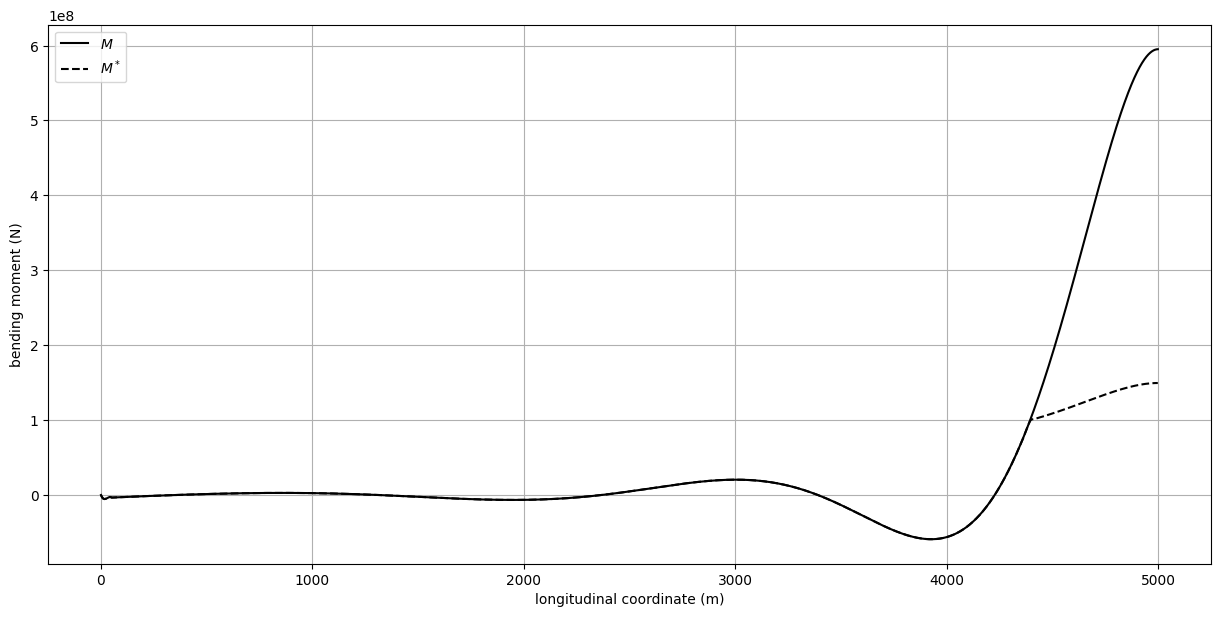

In [9]:
fig, ax = plt.subplots(figsize = (15, 7))
plt.plot(Function(Q).project(q[1]).at(X, tolerance = 1e-10), color = 'k', label = '$M$')
plt.plot(Function(Q).project(M_star).at(X, tolerance = 1e-10), color = 'k', linestyle = 'dashed', label  = '$M^*$')
plt.legend()
plt.ylabel('bending moment (N)')
plt.xlabel('longitudinal coordinate (m)')
# ax.set_yscale('log')
plt.grid()